<a href="https://colab.research.google.com/github/jirikadlec2/cloud_computing_workshop/blob/main/notebooks/lake_chad_wofs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the required packages if they are not already present
! pip install pystac_client odc-stac matplotlib pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 74.4 MB/s eta 0:00:00


In [2]:
# Importing the dependencies

from pystac_client import Client
from odc.stac import configure_rio, stac_load

import matplotlib.pyplot as plt
import pandas as pd

Configure the bands

In [3]:
config = {
    "s2_l2a": {
        "assets": {
            "*": {
                "data_type": "uint16"
            }
        },
        "aliases": {
            "costal_aerosol": "B01",
            "blue": "B02",
            "green": "B03",
            "red": "B04",
            "red_edge_1": "B05",
            "red_edge_2": "B06",
            "red_edge_3": "B07",
            "nir": "B08",
            "nir_narrow": "B08A",
            "water_vapour": "B09",
            "swir_1": "B11",
            "swir_2": "B12",
            "mask": "SCL",
            "aerosol_optical_thickness": "AOT",
            "scene_average_water_vapour": "WVP",
        },
    }
}

In [4]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

In [5]:
# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")

In [23]:
# Set a bounding box
# [xmin, ymin, xmax, ymax] in latitude and longitude
#bbox = [13.5, 13.7, 13.7, 13.9]
bbox = [13.1, 12.6, 15.1, 14.4]

# Set a start and end date
start_date = "1984-01-01"
end_date = "2025-07-01"

# Set the STAC collections
collections = ["wofs_ls_summary_annual"] #["gm_s2_rolling"]

In [24]:
# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 295 datasets


In [25]:
crs = "EPSG:6933"
resolution = 500

ds = stac_load(
    items,
    bands=("count_wet","count_clear",),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config,
    bbox=bbox,
)

# View the Xarray Dataset
ds

<xarray.Dataset> Size: 47MB
Dimensions:      (y: 448, x: 387, time: 34)
Coordinates:
  * y            (y) float64 4kB 1.818e+06 1.818e+06 ... 1.595e+06 1.595e+06
  * x            (x) float64 3kB 1.264e+06 1.264e+06 ... 1.456e+06 1.457e+06
    spatial_ref  int32 4B 6933
  * time         (time) datetime64[ns] 272B 1984-01-01 1985-01-01 ... 2024-01-01
Data variables:
    count_wet    (time, y, x) float32 24MB dask.array<chunksize=(1, 448, 387), meta=np.ndarray>
    count_clear  (time, y, x) float32 24MB dask.array<chunksize=(1, 448, 387), meta=np.ndarray>

In [29]:
ds["percent_wet"] = (ds.count_wet / ds.count_clear) * 100.0
percent_wet = ds.percent_wet.compute()


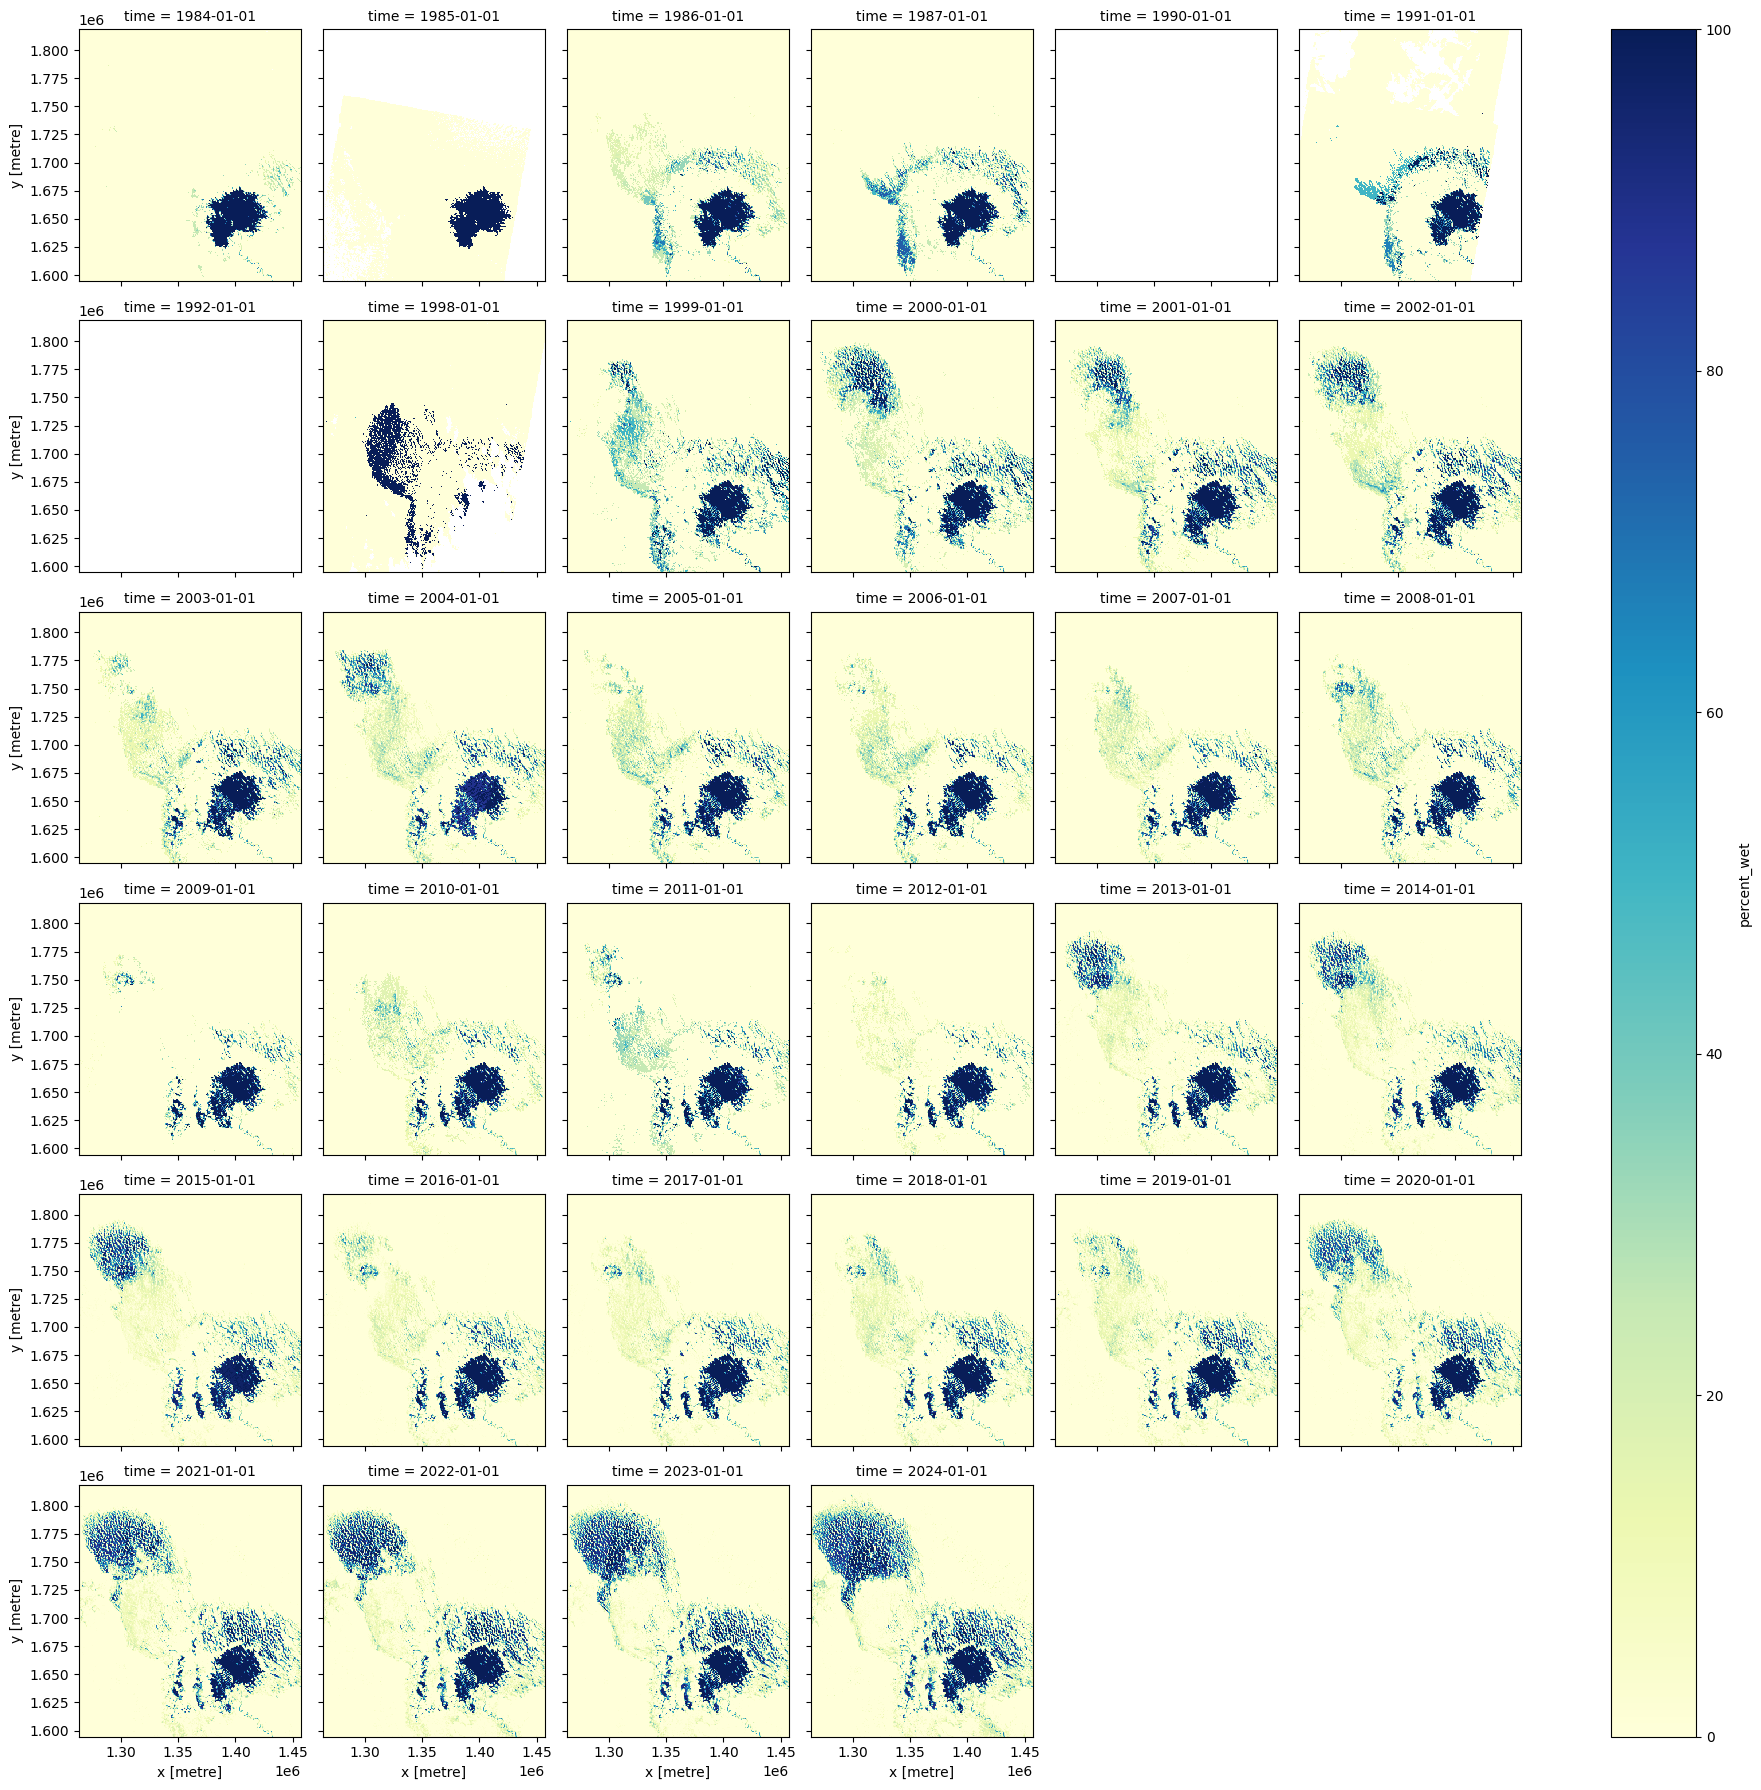

In [43]:
# Create a boolean mask for pixels where percent_wet is greater than 50%
from matplotlib.colors import ListedColormap
cmap_custom = ListedColormap(['white', 'blue'])

water_threshold = 90
water_mask = percent_wet > water_threshold
percent_wet.plot(col="time", col_wrap=6, cmap='YlGnBu')
#water_mask.plot(col="time", col_wrap=6, cmap=cmap_custom)

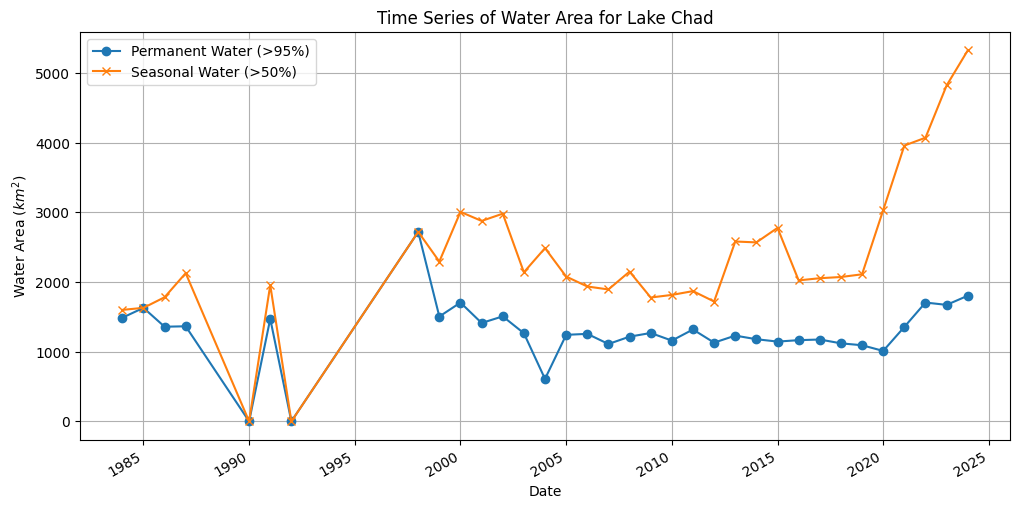

The combined time series data has been saved to water_area_time_series.csv


In [46]:
# Define the percent_wet to identify permanent water
permanent_water_threshold = 95
seasonal_water_threshold = 50

# Calculate the area of a single pixel in square kilometers
pixel_area_sq_m = resolution * resolution
pixel_area_sq_km = pixel_area_sq_m / 1000000.0

# Create a boolean mask for pixels where MNDWI is greater than the threshold (i.e., water)
permanent_water_mask = percent_wet > permanent_water_threshold

# Count the number of water pixels for each time step
permanent_water_pixel_count = permanent_water_mask.sum(dim=["x", "y"])

# Calculate the total water area in square kilometers for each time step
permanent_water_area_sq_km = permanent_water_pixel_count * pixel_area_sq_km

# Convert the xarray DataArray to a pandas Series for plotting
permanent_water_area_series = permanent_water_area_sq_km.compute().to_pandas()

# Same for seasonal water flooding
seasonal_water_mask = percent_wet > seasonal_water_threshold
seasonal_water_pixel_count = seasonal_water_mask.sum(dim=["x", "y"])
seasonal_water_area_sq_km = seasonal_water_pixel_count * pixel_area_sq_km

# Convert the xarray DataArray to a pandas Series for plotting
seasonal_water_area_series = seasonal_water_area_sq_km.compute().to_pandas()


# Plot the time series of water area
plt.figure(figsize=(12, 6))

# Plot the permanent water series with a label
permanent_water_area_series.plot(style='-o', label=f'Permanent Water (>{permanent_water_threshold}%)')

# Plot the seasonal water series with a label on the same chart
seasonal_water_area_series.plot(style='-x', label=f'Seasonal Water (>{seasonal_water_threshold}%)')

plt.title("Time Series of Water Area for Lake Chad")
plt.xlabel("Date")
plt.ylabel("Water Area ($km^2$)")
plt.grid(True)
plt.legend()  # Add this line to display the legend
plt.show()

# You can save both series to a single CSV file if you want
combined_series = pd.DataFrame({
    'permanent_water': permanent_water_area_series,
    'seasonal_water': seasonal_water_area_series
})
combined_series.to_csv("water_area_time_series.csv")

print("The combined time series data has been saved to water_area_time_series.csv")